In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from scipy import stats
from collections import Counter
import re
from datetime import datetime
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
from io import BytesIO
import ast

#image analysis: first install dlib in your ada environment (1: conda activate ada , 2: install dlib)
import dlib 
#face recognition library, first install it in your ada environment (1: conda activate ada, 2: install face_recognition)
import face_recognition
from PIL import Image, ImageDraw

# Abstract

Have you ever wondered why some actors keep getting cast in the same role? Why Dwayne Johnson always seems to plays the adventurous, headstrong and caring leader? Why Jason Staham is constantly cast as the gritty, hardboiled tough guy? And do these recurring casting choices lead to box office success? <br>
This phenomenon is called typecasting, in which an actor becomes strongly identified with particular roles, or characters having the same traits or coming from the same social or ethnic groups. The CMU Movies Summary Corpus has already observed 501 recurring character tropes. In this study, we want to analyse the physical aspects of these tropes, by decoding the features *(gender, age, ethnicity and facial features)* of the actors observing them throughout time and movie genres, before correlating these findings to the movie's box office success. <br>

### Project Plotline

### Part 1: Exploring and pre-processing the data
We are given a series of datasets in this corpus, with the metadata and tv tropes cluster being the data of most interest for us. This metadata is comprised of two dataframes, the movie metadata and the characters metadata. As indicated in the CMU Movie Summary Corpus ReadMe, these two dataframes have a many variables. Let us first identify the variables of interest for our story. <br>
- *Movie metadata: Wiki_movieID, Movie Name, Release Date, Box Office, Genres* <br>
- *Character metadata: Wiki_movieID, Release Date, Character Name, Gender, Height, Ethinicity, Actor Name, Age at Movie Release* <br>

**Step 1: Movie and Characters MetaData** <br>
+ We plot our variables of interest to visualise the coherence of our data before fixing any errors. <br>
+ We analyse the percentage of missing data, giving us insight on the datasets we should use to complete our study. <br>
+ We merge movies.metadata.tsv with characters.metadata.tsv to associate the characters with their respective genres, movie box office revenue and decade of release. <br>
    
**Step 2: TV Tropes** <br>
+ We pre-process our tvtropes.clusters.txt file and merge it with our merged character and movies metadata. <br>
+ We identify 501 character tropes with 72 unique archetypes. As such, we focus on these 501 tropes and their associated characters, actors and movies. We identify 350 actors corresponding to these 501 character archetypes. <br>
+ We merge TV Tropes with Movie and Character MetaData. <br>
+ We complete key missing data *(ActorEthnicity and ActorAge)*. <br>
+ We plot the number of tropes in function of movie genres to identify which genres we can remove from our dataset. <br>
    
**Step 3: Extracting Actor Images** <br>
+ We extract the 350 actor images from [The Movie Database](https://www.themoviedb.org/) to create the Actor_image.csv dataset. <br>

### Part 2: Clustering our data
**Step 4: Clustering Tropes** <br>
+ We have 72 unique character tropes. This gives an average of 7 characters per trope. This is too little data for any significant analysis. As such, we decide to cluster similar tropes together to give us a more subsequent amount of characters per clustered trope. <br>
    
**Step 5: Clustering Ethnicities** <br>
+ Similarly to our character tropes, we identify a large number of unique ethnicities. With the same reasoning as for the tropes, we cluster our ethnicities together for better analysis. <br>
    
### Part 3: Facial Image Analysis
**Step X: Analysing Facial Features** <br>
+ We analyse and quantify the facial features of our actor images using a facial recognition algorithm. <br>

#### Ethical Risks of our study
+ CMU Movie Summaries Corpus regroups a mix of nationalities and ethnicities for ActorEthnicity *(for example: Japanese Brasilians)*. We decided to cluster similar ActorEthnicity values together. This runs the risk of misrepresentation as we will potentially different ethnic groups together.
+ We use and analyze actor images from [The Movie Database](https://www.themoviedb.org/) (TMDB). As such, we are subject to the conditions detailed in TMDB's [Terms of Use](https://www.themoviedb.org/terms-of-use), notably in terms of the actors' image consent.

## Step 1: Movie and Characters MetaData

### a) Loading Data and Identifying variables of interest

In [2]:
#Loading our data
characters_df = pd.read_csv('data/character.metadata.tsv', delimiter="\t", 
                            names=['Wiki_movieID', 'Freebase_movieID', 'ReleaseDate', 'CharacterName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 'ActorName', 'ActorAge', 'Freebase_charactermap', 'Freebase_characterID', 'Freebase_actorID'])
movies_df = pd.read_csv('data/movie.metadata.tsv', delimiter="\t", 
                        names=['Wiki_movieID', 'Freebase_movieID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

#We look at the length and shape of our initial dataframes.
print("Size of 'Characters' DataFrame: %d" % len(characters_df))
print("Size of 'Movies' DataFrame: %d" % len(movies_df))

print("Shape of 'Characters' DataFrame: %d" % characters_df.shape[1])
print("Shape of 'Movies' DataFrame: %d" % movies_df.shape[1])

Size of 'Characters' DataFrame: 450669
Size of 'Movies' DataFrame: 81741
Shape of 'Characters' DataFrame: 13
Shape of 'Movies' DataFrame: 9


In [3]:
characters_df.head(1)

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


In [4]:
movies_df.head(1)

,Wiki_movieID,Freebase_movieID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


We identify the variables of interest for our project.
+ Movie metadata: *Wiki_movieID, MovieName, ReleaseDate, Genres, BoxOffice* <br>
+ Character metadata: *Wiki_movieID, ReleaseDate, CharacterName, ActorGender, ActorHeight, ActorEthinicity, ActorName, ActorAge* <br>

### b) Cleaning and Sorting our Data

In [5]:
#Functions
def percentage_missingdata(dataframe, column_name):
    notmissing = dataframe[column_name].count()
    totaldata = len(dataframe[column_name])
    percentage_missing = (1 - (notmissing/totaldata)) * 100
    
    return percentage_missing

def is_valid_date(date_string, format_string):
    try:
        datetime.strptime(date_string, format_string)
        return True
    except ValueError:
        return False

In [6]:
#change the {} into NaNs
movies_df.replace({'{}': pd.NA}, inplace=True)
characters_df.replace({'{}': pd.NA}, inplace=True)

#### b.i) Sorting and Visualising our Movie Dataframe

##### Decades of Release

In [7]:
#We start by classifying our data per decades of release dates.
#Keeping only the year of release of the movies to classify them by decades
format1 = "%Y-%m-%d"
format2 = "%Y-%m"

for y in range(len(movies_df)):
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format1):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], format1)
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format2):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], format2)
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
movies_df['ReleaseDate'] = movies_df['ReleaseDate'].astype(float)
movies_df.sort_values(by='ReleaseDate', ascending=True, inplace=True)

#Visualization
display(movies_df[['MovieName', 'ReleaseDate', 'Genres', 'BoxOffice']].head(3))

,MovieName,ReleaseDate,Genres,BoxOffice
62836,Hunting Season,1010.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...",12160978.0
57963,Roundhay Garden Scene,1888.0,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
38764,"Leisurely Pedestrians, Open Topped Buses and H...",1889.0,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN


>We notice an error in the movies dataset. The movie 'Hunting Season' is said to have a release date in 1010. This is impossible as the first movie was made in 1888, named 'Roundhay Garden Scene'. <br>
>A quick google search reveals that the movie's actual release year was 2010. Let us fix that.

In [8]:
huntingseason_error = movies_df.loc[movies_df['MovieName'] == 'Hunting Season'].index
movies_df.loc[huntingseason_error,'ReleaseDate'] = 2010.0

display(movies_df[['MovieName', 'ReleaseDate', 'Genres', 'BoxOffice']].head(4))

,MovieName,ReleaseDate,Genres,BoxOffice
62836,Hunting Season,2010.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...",12160978.0
57963,Roundhay Garden Scene,1888.0,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
38764,"Leisurely Pedestrians, Open Topped Buses and H...",1889.0,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
53907,"Monkeyshines, No. 1",1890.0,"{""/m/06ppq"": ""Silent film""}",NaN


> We notice two movies released in 1888 and 1889. To not have just two values in the 1880s decade, we decide to add these two movies to the 1890s.

In [9]:
#This function returns the decade of the movie's release date.
def get_decade(year):
    return (year // 10) * 10

#Let us start by adding the decades to movies_df
if 'Decade' not in movies_df.columns:
    movies_df.insert(5, 'Decade', None)

movies_df['Decade'] = movies_df['ReleaseDate'].apply(lambda x: get_decade(x))

#As said earlier, we add the two movies released in 1888 and 1889 to the 1890s decades. 
decade_change1 = movies_df.loc[movies_df['ReleaseDate'] == 1888].index
movies_df.loc[decade_change1,'Decade'] = 1890.0

decade_change2 = movies_df.loc[movies_df['ReleaseDate'] == 1889].index
movies_df.loc[decade_change2,'Decade'] = 1890.0

movies_df.sort_values(by='ReleaseDate' , ascending=True, inplace=True)
display(movies_df[['MovieName', 'Genres', 'Decade', 'ReleaseDate']].head(3))

,MovieName,Genres,Decade,ReleaseDate
57963,Roundhay Garden Scene,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1890.0,1888.0
38764,"Leisurely Pedestrians, Open Topped Buses and H...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1890.0,1889.0
53907,"Monkeyshines, No. 1","{""/m/06ppq"": ""Silent film""}",1890.0,1890.0


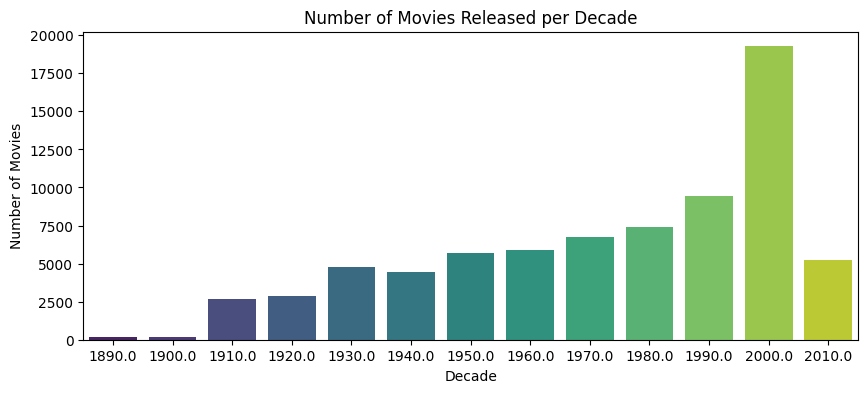

In [10]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Decade', data=movies_df, palette='viridis')
plt.title('Number of Movies Released per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.show()

> We observe a gradual increase in number of movies until the 1980s *(with a drop in the 1940s due to WWII)* with a sudden burst in movie quantity in the 1990s and 2000s. <br>
> There is a small sample size for the 2010s because the data collected until 2016 only.

##### Movie Genres

In [11]:
#Keeping only the name of the genre in our dataframe

genre_names_list = []

for gen in range(len(movies_df)):
    if pd.notna(movies_df['Genres'][gen]) and isinstance(movies_df['Genres'][gen], str):
        genre_dict = json.loads(movies_df['Genres'][gen])
        genre_names = list(genre_dict.values())
        genre_names_list.append(genre_names)
    else:
        genre_names_list.append(pd.NA)

movies_df.sort_index(ascending=True, inplace=True)
movies_df['Genres'] = genre_names_list

In [12]:
#Flattening all the genres list into one single list
copy = movies_df.copy()
movies_df_exploded = copy.explode('Genres')
movies_df_exploded = movies_df_exploded[movies_df_exploded['Genres'] != '{}']
flattened_list = movies_df_exploded['Genres'].tolist()

genres_counts = Counter(flattened_list)
counts_df = pd.DataFrame.from_dict(genres_counts, orient='index', columns=['Count'])

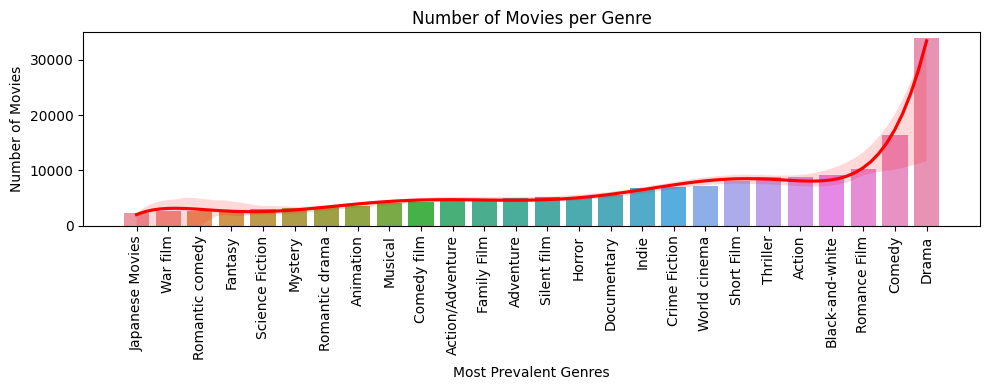

In [13]:
#Plotting movies by genres

#We notice that there's 2294 counts of films with missing genres, characterised by an NaN value. 
#As such we determine our threshold to be over 2300 for the genre occurences.
counts_df = counts_df[counts_df['Count'] >= 2300]

counts_df.sort_values(by='Count', ascending=True, inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x=counts_df.index.tolist(), y=counts_df['Count'])
sns.regplot(x=np.arange(len(counts_df)), y=counts_df['Count'], order=7, scatter=False, color='red')
plt.xticks(rotation=90)
plt.ylim(bottom=0, top=35000)
plt.xlabel('Most Prevalent Genres')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.tight_layout()
plt.show()

> We observe the 26 most prevalent movie genres in our database *(with more than 2400 movies per genre)* <br>
> A majority of the movies are dramas.

#### b.ii) Checking the percentage of missing data for each variable of interest

In [14]:
#Missing data in movies_df
movie_variables = ['Wiki_movieID', 'MovieName', 'ReleaseDate','Genres', 'BoxOffice']
percentage_missing_movies = []

percentage_missing_movies = [percentage_missingdata(movies_df, var) for var in movie_variables]

missing_data_movies_df = pd.DataFrame({'Variables of Interest': movie_variables,
                                           'Percentage of Missing Data': percentage_missing_movies})  


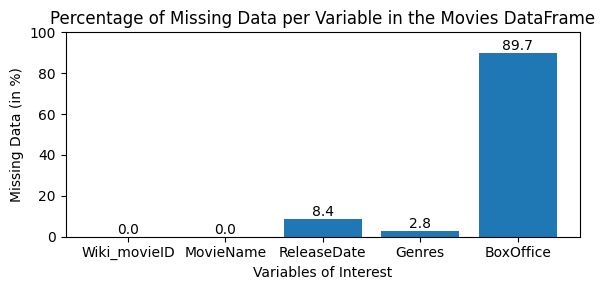

In [15]:
#Plotting the percentage of missing data for the variables of movies_df
plt.figure(figsize=(6, 3))
bars = plt.bar(missing_data_movies_df['Variables of Interest'], missing_data_movies_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Variables of Interest')
plt.ylabel('Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Movies DataFrame')
plt.tight_layout()
plt.show()

>We observe 0% of missing data for Wiki_movieID and Movie Name. We can associate each movie to its respective Wikipedia Page using WikiData without any errors.<br>
>We have 8.4% of missing data for Release Date variable and 2.8% for Genres variable. These values are both very low and under 10%. Generally, when we have more than 10% of missing data, our data is likely to be biased. As such this is not the case for these two variables.<br>
>We see however 89.7% of missing data for the BoxOffice variable, an astonishing amount. This will mean that our BoxOffice is very likely to be biased towards the movies that have a BoxOffice value.<br>

In [16]:
#Missing data in characters_df
character_variables = ['Wiki_movieID', 'ReleaseDate', 'CharacterName','ActorGender', 'ActorHeight', 
                                                    'ActorEthnicity', 'ActorName', 'ActorAge','ActorDOB']
percentage_missing_characters = []

percentage_missing_characters = [percentage_missingdata(characters_df, var) for var in character_variables]

missing_data_characters_df = pd.DataFrame({'Variables of Interest': character_variables,
                                           'Percentage of Missing Data': percentage_missing_characters})                                                                                                                             

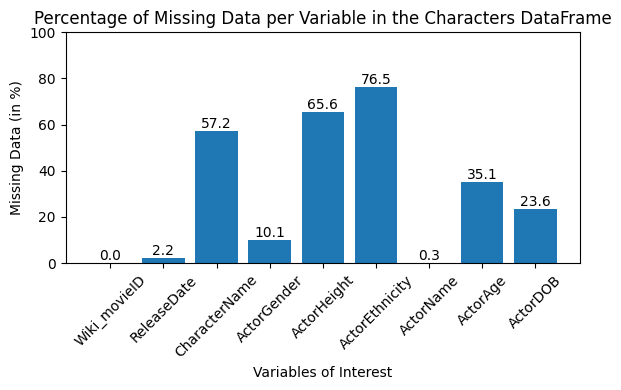

In [17]:
#Plotting the percentage of missing data for the variables of characters_df
plt.figure(figsize=(6, 4))
bars = plt.bar(missing_data_characters_df['Variables of Interest'], missing_data_characters_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.xlabel('Variables of Interest')
plt.ylabel('Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Characters DataFrame')
plt.tight_layout()
plt.show()

>We observe a high percentage of missing data for our respective variables of interest, the notable ones being *CharacterName*, *ActorHeight*, *ActorEthnicity* and *ActorDOB*, *ActorAge*.<br>
> For character name, this missing data is to be expected as many characters in movies do not have names, being background characters. Their character roles are much more interesting for our analysis. <br>
> Similarly, the missing data in actor age and actor date of birth (DOB) is not an issue as we can use DOB and Release Date to calculate the actor's age. The inverse is true to find the DOB. We can clean these missing values. <br>
> Our biggest concern is with the large quantity of missing data in both actor height and ethnicity as they are both key features to our project idea. We can use WikiData to complete our data. <br>

### c) Merging Movie and Character DataFrames


In [18]:
characters_movies_df = movies_df.merge(characters_df, on=['Wiki_movieID'], how = 'left', suffixes=("", "_y")).drop(['Freebase_movieID_y', 'ReleaseDate_y'], axis=1)

#Visualization
display(characters_movies_df[['CharacterName', 'ActorName', 'ActorAge', 'ActorDOB', 'ActorEthnicity',
                                  'ActorGender','ActorHeight', 'MovieName', 'Genres', 'Decade', 'ReleaseDate', 'BoxOffice']].head(3))

,CharacterName,ActorName,ActorAge,ActorDOB,ActorEthnicity,ActorGender,ActorHeight,MovieName,Genres,Decade,ReleaseDate,BoxOffice
0,Akooshay,Wanda De Jesus,42.0,1958-08-26,NaN,F,1.620,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...",2000.0,2001.0,14010832.0
1,Lieutenant Melanie Ballard,Natasha Henstridge,27.0,1974-08-15,/m/044038p,F,1.780,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...",2000.0,2001.0,14010832.0
2,Desolation Williams,Ice Cube,32.0,1969-06-15,/m/0x67,M,1.727,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...",2000.0,2001.0,14010832.0


In [19]:
#Counting the number of characters per movie genre
characters_movies_copy = characters_movies_df.copy()
c_m_exploded = characters_movies_copy.explode('Genres')
c_m_exploded = c_m_exploded[c_m_exploded['Genres'] != '{}']
flat_list = c_m_exploded['Genres'].tolist()

charac_counts = Counter(flat_list)
charac_counts_df = pd.DataFrame.from_dict(charac_counts, orient='index', columns=['Count'])

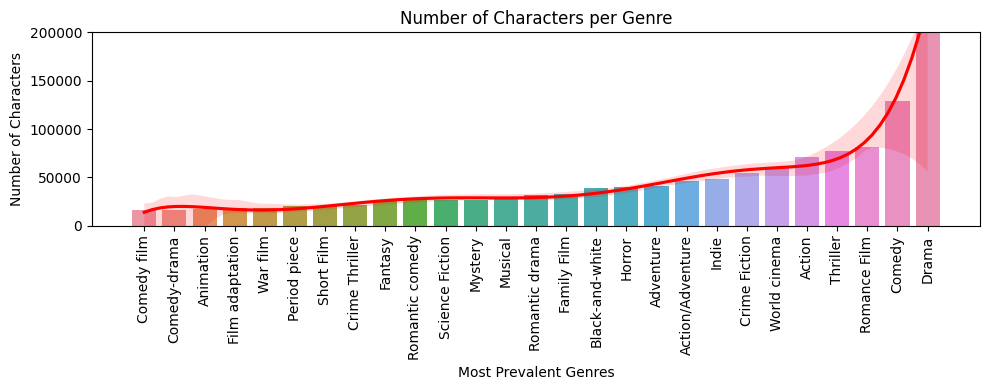

In [20]:
charac_counts_df = charac_counts_df[charac_counts_df['Count'] >= 15000]

charac_counts_df.sort_values(by='Count', ascending=True, inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x=charac_counts_df.index.tolist(), y=charac_counts_df['Count'])
sns.regplot(x=np.arange(len(charac_counts_df)), y=charac_counts_df['Count'], order=7, scatter=False, color='red')
plt.xticks(rotation=90)
plt.ylim(bottom=0, top=200000)
plt.xlabel('Most Prevalent Genres')
plt.ylabel('Number of Characters')
plt.title('Number of Characters per Genre')
plt.tight_layout()
plt.show()

>We plot the number of characters per genre. The distribution matches the earlier plotted distribution of number of movies per genre with a majority of characters being in dramas or comedies.

## Step 2: TV Tropes

### a) Visualising our TV Tropes Dataframe

In [21]:
df_tropes_original = pd.read_csv('data/tvtropes.clusters.txt', delimiter="\t", names=['trope', 'character'])
json_obj = df_tropes_original['character'].apply(json.loads)
df_tropes_norm = pd.json_normalize(json_obj[0])

for i in range(1, len(json_obj)):
    df_norm = pd.json_normalize(json_obj[i])
    df_tropes_norm = pd.concat([df_tropes_norm, df_norm], ignore_index=True)

tropes_df = pd.concat([df_tropes_original.drop('character', axis=1), df_tropes_norm], axis=1)

tropes_df = tropes_df.rename(columns={'id': 'Freebase_charactermap', 'char':'CharacterName', 'actor':'ActorName', 'movie':'MovieName'})

#Visualizing tropes_df data
display(tropes_df.head())
print("Size of 'Tropes' DataFrame: %d" % len(tropes_df))
print("Shape of 'Tropes' DataFrame: %d" % tropes_df.shape[1])

,trope,CharacterName,MovieName,Freebase_charactermap,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


Size of 'Tropes' DataFrame: 501
Shape of 'Tropes' DataFrame: 5


>We visualise our tvtropes.clusters as a dataframe and we observe 501 character tropes with 72 unique types. We will now merge it with our characters_movies_df to associate the characters to their respective tropes. <br> 
>We will then check for missing data in this new merged dataframe. <br>

### b) Merging Character & Movies Dataframe on TV Tropes

In [22]:
# population de tropes_df with the df containing the movies and characters
tropes_movie_character_df= pd.merge(tropes_df, characters_movies_df, on=['CharacterName', 'ActorName', 'MovieName', 'Freebase_charactermap'], how='left').drop(['Runtime', 'Languages', 'Countries','Freebase_characterID'], axis=1)
new_order=['Freebase_charactermap', 'trope', 'CharacterName', 'ActorName', 'ActorAge','ActorDOB', 'ActorEthnicity', 'ActorGender', 'ActorHeight', 'Freebase_actorID', 'MovieName', 'Genres','Decade', 'ReleaseDate', 'BoxOffice', 'Freebase_movieID','Wiki_movieID' ]
tropes_movie_character_df=tropes_movie_character_df[new_order]
tropes_movie_character_df=tropes_movie_character_df.rename(columns={'trope': 'Trope'})
tropes_movie_character_df=tropes_movie_character_df.sort_values('Trope')

#Visualiszing our merged dataframe, tropes_movie_character_df:
display(tropes_movie_character_df[['Trope', 'CharacterName', 'ActorName', 'ActorAge', 'ActorDOB', 'ActorEthnicity',
                                  'ActorGender','ActorHeight', 'MovieName', 'Genres', 'Decade', 'ReleaseDate', 'BoxOffice']]
                                  .head(3))
print("Size of 'Tropes-Movie-Character' DataFrame: %d" % len(tropes_movie_character_df))
print("Shape of 'Tropes-Movie-Character' DataFrame: %d" % tropes_movie_character_df.shape[1])

,Trope,CharacterName,ActorName,ActorAge,ActorDOB,ActorEthnicity,ActorGender,ActorHeight,MovieName,Genres,Decade,ReleaseDate,BoxOffice
0,absent_minded_professor,Professor Philip Brainard,Robin Williams,46.0,1951-07-21,NaN,M,1.702,Flubber,"[Science Fiction, Fantasy, Comedy, Family Film...",1990.0,1997.0,177977226.0
1,absent_minded_professor,Professor Keenbean,Michael McShane,39.0,1955-06-25,NaN,M,NaN,Richie Rich,"[Family Film, Adventure Comedy, Comedy]",1990.0,1994.0,38087756.0
2,absent_minded_professor,Dr. Reinhardt Lane,Ian McKellen,55.0,1939-05-25,NaN,M,1.800,The Shadow,"[Thriller, Crime Fiction, Supernatural, Superh...",1990.0,1994.0,48063435.0


Size of 'Tropes-Movie-Character' DataFrame: 501
Shape of 'Tropes-Movie-Character' DataFrame: 17


>The size of our dataframe matches the size of our Tropes DataFrame indicating a correct merge. We have associated the 501 character tropes to their respective characters, movies and features *(Actor Name, Movie Genre, Actor Ethnicity...)*.

### c) Visualising the missing data in TV Tropes

In [23]:
#Missing data for tropes
tropes_variables = ['Wiki_movieID', 'MovieName', 'ReleaseDate','Genres', 'BoxOffice', 'CharacterName','ActorGender', 'ActorHeight', 
                                                    'ActorEthnicity', 'ActorName', 'ActorAge','ActorDOB']
percentage_missing_tropes_data = []

percentage_missing_tropes_data = [percentage_missingdata(tropes_movie_character_df, var) for var in tropes_variables]
    
missing_data_tropes_df = pd.DataFrame({'Variables of Interest': tropes_variables,
                                           'Percentage of Missing Data': percentage_missing_tropes_data})

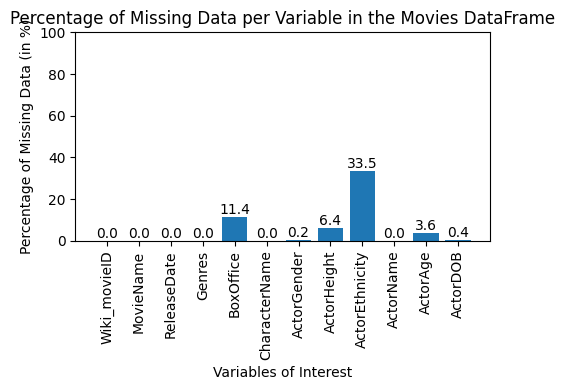

In [24]:
#Plotting the percentage of missing data for the variables of missing_data_tropes_df
plt.figure(figsize=(5, 4))
bars = plt.bar(missing_data_tropes_df['Variables of Interest'], missing_data_tropes_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Variables of Interest')
plt.ylabel('Percentage of Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Movies DataFrame')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

>We notice a dramatic decrease in missing data compared to our movies_df and characters_df dataframes, with relatively small amounts for all the variables of interests except *ActorEthnicity*. <br>
>We will now clean our data, starting with the 3.6% of missing data in Actor Age that we can easily fix using ActorDOB. <br>

#### c.i) Filling the missing data in Actor Age

In [25]:
#Finding the entries missing both ActorAge and ActorDOB
missing_age=tropes_movie_character_df[tropes_movie_character_df['ActorAge'].isna() & tropes_movie_character_df['ActorDOB'].isna()]

#Display the entries missing both ActorAge and ActorDOB
display(missing_age[['Trope', 'CharacterName', 'ActorName', 'ActorAge', 'ActorDOB', 'ReleaseDate']])

,Trope,CharacterName,ActorName,ActorAge,ActorDOB,ReleaseDate
233,evil_prince,Prince Otwani,Trevor Thomas,NaN,NaN,1984.0
227,evil_prince,Prince Yu,Junjie Qin,NaN,NaN,2006.0


> As before, we want to fill the 3.6% of missing data in Actor Age by calculating it with the date of birth of the actor and the year of release. 
> As noted in the table above, only two actors do not have either Actor Age or Date of Birth, as such we might have to manually fill in the data for these two actors.

In [26]:
#Converting DOB to Years
for y in range(len(tropes_movie_character_df)):
    if isinstance(tropes_movie_character_df['ActorDOB'][y], str):
        if is_valid_date(tropes_movie_character_df['ActorDOB'][y],format1):
            date_obj = datetime.strptime(tropes_movie_character_df['ActorDOB'][y], format1)
            tropes_movie_character_df.loc[y,'ActorDOB'] = date_obj.year

In [27]:
#Calculating Actor Ages and filling the missing data
tropes_movie_character_df['ActorDOB'] = tropes_movie_character_df['ActorDOB'].astype(float)

tropes_movie_character_df['ActorAge'] = tropes_movie_character_df['ReleaseDate'] - tropes_movie_character_df['ActorDOB']

In [28]:
#Checking missing data in ActorAge again
age_variables = ['ActorAge','ActorDOB']
percentage_missing_tropes_age = []

percentage_missing_tropes_age = [percentage_missingdata(tropes_movie_character_df, var) for var in age_variables]
  
missing_data_tropes_age = pd.DataFrame({'Variables of Interest': age_variables,
                                           'Percentage of Missing Data': percentage_missing_tropes_age})

print(missing_data_tropes_age)

  Variables of Interest  Percentage of Missing Data
0              ActorAge                    0.399202
1              ActorDOB                    0.399202


>As seen in the table above, we have successfully completed the missing data in Actor Age, with the percentage decreasing from 3.6% to 0.399% *(the percentage of missing data for ActorDOB)*. <br>
>With a quick calculation, we observe that the remaining 0.399% of missing data in Actor Age and Actor Date of Birth corresponds to the two actors we identified earlier who do not have values for both ActorAge and ActorDOB. Let us manually add these values to our data frame. <br>
<br>
> Our missing actors and characters are: <br> - *Prince Otwani played by Trevor Thomas in the movie 'Sheena'*  <br> - *Prince Yu played by Junjie Qin in the movie 'Curse of the Golden Flower'* <br>
> Upon printing the rows with missing data for both ActorAge and ActorDOB above, we identified the indexes for both missing values: index 233 for Trevor Thomas and 227 for Junjie Qin.

In [29]:
tropes_movie_character_df.loc[227,'ActorDOB'] = 1991.0
tropes_movie_character_df.loc[227, 'ActorAge'] = tropes_movie_character_df['ReleaseDate'][227] - tropes_movie_character_df['ActorDOB'][227] 

> Despite our best efforts, we could not find any information on Trevor Thomas on his date of birth or age. As such, we decide to leave him as a missing value for our dataframe.

In [30]:
#We print the percentage of missing data for tropes_movie_character_df one last time.
percentage_missing_tropes_age_new = []

percentage_missing_tropes_age_new = [percentage_missingdata(tropes_movie_character_df, var) for var in age_variables]
    
missing_data_tropes_age_new = pd.DataFrame({'Variables of Interest': age_variables,
                                           'Percentage of Missing Data': percentage_missing_tropes_age_new})

print(missing_data_tropes_age_new)

  Variables of Interest  Percentage of Missing Data
0              ActorAge                    0.199601
1              ActorDOB                    0.199601


> We now have less than 0.2% of missing data for both ActorDOB and ActorAge.

In [32]:
missing_ethn=tropes_movie_character_df[tropes_movie_character_df['ActorEthnicity'].isna()]

print('The number of actors with missing ActorEthnicity values: %d' %len(missing_ethn['ActorName']))
print('This matches the 33.5% of missing data calculated above.')


The number of actors with missing ActorEthnicity values: 168
This matches the 33.5% of missing data calculated above.


#### d) Transforming the ActorEthnicity label in a string using [WikiData](https://query.wikidata.org/sparql)

> We observe that the ActorEthnicity is charactertised by a label, for example */m/09v5bdn*. Let us use WikiData to retrieve these labels and display them in a readable fashion.

In [33]:
def get_ethnicity(freebase_id):
    # get the label of the freebase ID from Wikidata
    # Args: freebase_id: the freebase ID to be decoded
    # Returns: label, the corresponding label of the Wikidata ID (and a specific text for when)
    
    endpoint_url = "https://query.wikidata.org/sparql"
    query = """
    SELECT ?item ?itemLabel WHERE {
      ?item wdt:P646 '""" + freebase_id + """'.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    """
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        results = sparql.query().convert()
        if results["results"]["bindings"]:
            label = results["results"]["bindings"][0]["itemLabel"]["value"]
            return label
        else:
            return "Label not found for the specified Freebase ID"
    except Exception as e:
        return np.nan

In [46]:
# groups by ethnicity, to get all the different ethnicities in one table
temp_df = tropes_movie_character_df['ActorEthnicity'].groupby(tropes_movie_character_df['ActorEthnicity']).agg(['count'])
temp_df = temp_df.reset_index()
temp_df.head(3)

,ActorEthnicity,count
0,/m/01336l,1
1,/m/013b6_,1
2,/m/019kn7,2


> As seen above, we have all the ethnicities in one table labelled in a key. We will use WikiData match every freebase ethnicity ID to its corresponding word.

In [35]:
#Match every freebase ethnicity ID to the ethnicity, if it found in Wikidata
temp_temp_df = temp_df.copy()
et = []
for i in range(len(temp_df['ActorEthnicity'])):
    df_temp_ethnicity = temp_df.iloc[i:i+1]
    for ethnicity in df_temp_ethnicity['ActorEthnicity'] :
        eth_tra = get_ethnicity(ethnicity)
        j = 0
        while ((type(eth_tra) == float) & (j<100)):
            #print(type(get_ethnicity(ethnicity)))
            eth_tra = get_ethnicity(ethnicity)
            j += 1
        et.append(eth_tra)

In [36]:
temp_temp_df['StrActorEthnicity'] = et

In [47]:
#convert to string every ethnicity taken from Wikidata
tmp = []
for i in range (len(temp_temp_df['StrActorEthnicity'])):
    if not (pd.isna(temp_temp_df['StrActorEthnicity'][i])):
        tmp.append(str(temp_temp_df['StrActorEthnicity'][i]))
    else:
        tmp.append(temp_temp_df['StrActorEthnicity'][i])
temp_temp_df['StrActorEthnicity'] = tmp
ethnicity_decoding = temp_temp_df

#len(ethnicity_decoding['StrActorEthnicity'])
ethnicity_decoding.head()

,ActorEthnicity,count,StrActorEthnicity
0,/m/01336l,1,Asian Americans
1,/m/013b6_,1,Ashkenazi Jews
2,/m/019kn7,2,Japanese people
3,/m/019lrz,1,Austrians
4,/m/01j2qv,1,Korean American


> We associated the Actor Ethnicity labels to their respective strings. We observe another issue though. <br>
> We have a very large number of ethnicities with very precise descriptions, for example *Asian American, Korean American...* We decide to simplify and group our ethnicities together. <br>
> We do this by deleting the word *"people"* and "*person*" after space, allowing for example *Irish* and *Irish people* to merge into the same category. We also assume the first ethnicity to be more representative then "*american"*. For example, "*Korean American*" will be labelled in our dataset as *Korean*. <br>
> We also transform all the uppercases into lowercases. <br>

In [48]:
# simplifying the ethnicity_decoding dataframe. 
simple_ethnicity_decoding = ethnicity_decoding.copy()
simple_ethnicity_decoding['StrActorEthnicity'] = simple_ethnicity_decoding['StrActorEthnicity'].str.replace(' Americans', '')
simple_ethnicity_decoding['StrActorEthnicity'] = simple_ethnicity_decoding['StrActorEthnicity'].str.replace(' American', '')
simple_ethnicity_decoding['StrActorEthnicity'] = simple_ethnicity_decoding['StrActorEthnicity'].str.replace(' people', '')
simple_ethnicity_decoding['StrActorEthnicity'] = simple_ethnicity_decoding['StrActorEthnicity'].str.replace(' person', '')
simple_ethnicity_decoding['StrActorEthnicity'] = simple_ethnicity_decoding['StrActorEthnicity'].str.lower()
len(simple_ethnicity_decoding['StrActorEthnicity'].unique())
simple_ethnicity_decoding.head()

,ActorEthnicity,count,StrActorEthnicity
0,/m/01336l,1,asian
1,/m/013b6_,1,ashkenazi jews
2,/m/019kn7,2,japanese
3,/m/019lrz,1,austrians
4,/m/01j2qv,1,korean


>We observe the results of ethnicity simplication above, with *Asian American* becoming *Asian* etc

In [39]:
tropes_characters_ethnicity_df = tropes_movie_character_df.merge(simple_ethnicity_decoding, on='ActorEthnicity', how='left').drop(['count'], axis = 1)
tropes_characters_ethnicity_df.sort_values(by='CharacterName', ascending=True, inplace=True)
tropes_characters_ethnicity_df = tropes_characters_ethnicity_df.rename(columns={'ActorEthnicity': 'ActorEthnicity Label'})

#Visualizing our data
display(tropes_characters_ethnicity_df[['Trope', 'CharacterName', 'ActorName', 'ActorEthnicity Label', 'StrActorEthnicity']].head())

,Trope,CharacterName,ActorName,ActorEthnicity Label,StrActorEthnicity
399,pupil_turned_to_evil,Aaron Hallam,Benicio del Toro,/m/09v5bdn,puerto ricans
177,dirty_cop,Abel Turner,Samuel L. Jackson,/m/0x67,african
342,loveable_rogue,Abu,Sabu Dastagir,/m/01336l,asian
79,byronic_hero,Achilles,Brad Pitt,NaN,NaN
329,junkie_prophet,Agatha,Samantha Morton,/m/02w7gg,english


> As seen above, we successfully retrieved the actor ethnicities for the 67.5% of actors with ActorEthnicity labels.

In [49]:
#finding the number of labels for which the function was unable to retrieve a label, the ethnicity is saved as 'Label not found for the specified Freebase ID'
missing_label_df = tropes_characters_ethnicity_df[tropes_characters_ethnicity_df['StrActorEthnicity'].str.contains('Label', case=False, na=False)]

#we replace the text 'Label not found for the specified Freebase ID' by np.Na as it is unusable data
tropes_characters_ethnicity_df['StrActorEthnicity'].replace({'label not found for the specified freebase id': pd.NA}, inplace=True)

In [50]:
#Counting the number of characters per ethnicity
tropes_characters_ethnicity_copy = tropes_characters_ethnicity_df.copy().dropna()
flat_list_ethn = tropes_characters_ethnicity_copy['StrActorEthnicity'].tolist()

tropes_counts = Counter(flat_list_ethn)
tropes_counts_df = pd.DataFrame.from_dict(tropes_counts, orient='index', columns=['Count'])

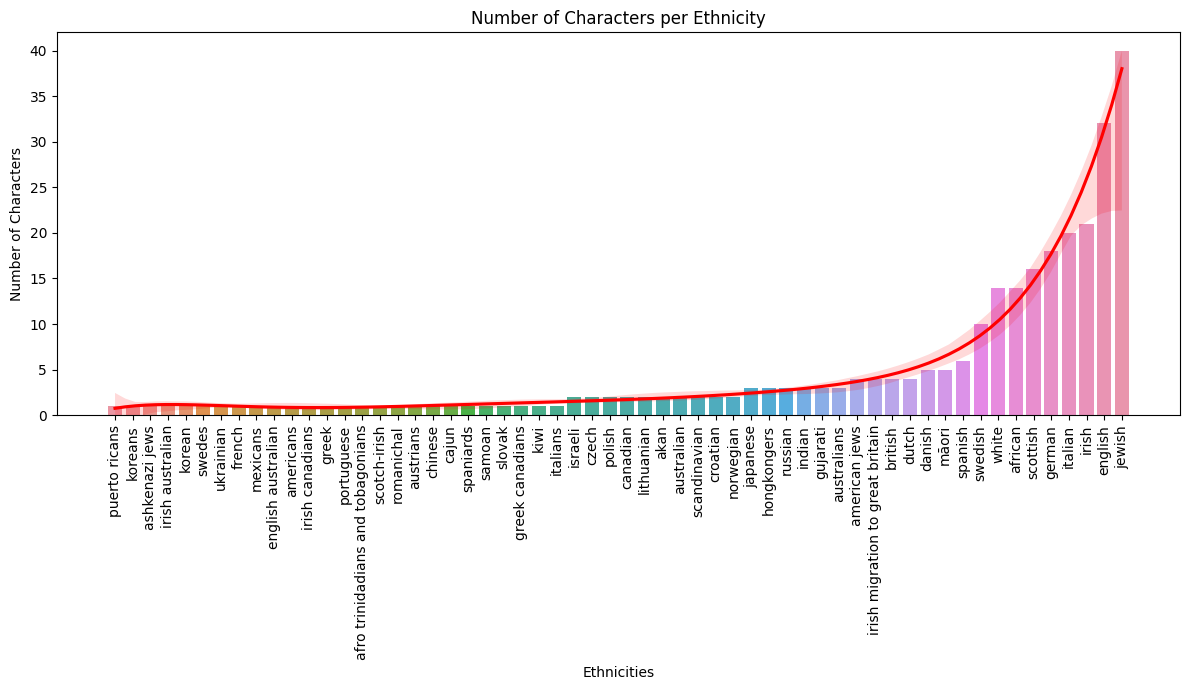

In [51]:
# plotting the number of characters per ethnicity using the counts from the previous cell
fig, ax = plt.subplots(figsize=(12, 7))

tropes_counts_df.sort_values(by='Count', ascending=True, inplace=True)

sns.barplot(x=tropes_counts_df.index.tolist(), y=tropes_counts_df['Count'])
sns.regplot(x=np.arange(len(tropes_counts_df)), y=tropes_counts_df['Count'], order=7, scatter=False, color='red', ax=ax)
plt.xticks(rotation=90)
plt.ylim(bottom=0, top=42)
plt.xlabel('Ethnicities')
plt.ylabel('Number of Characters')
plt.title('Number of Characters per Ethnicity')
plt.tight_layout()
plt.show()

### d) Plotting the data in our merged tropes_characters df

#### d.i) Univariate Exploratory Data Analysis (EDA)

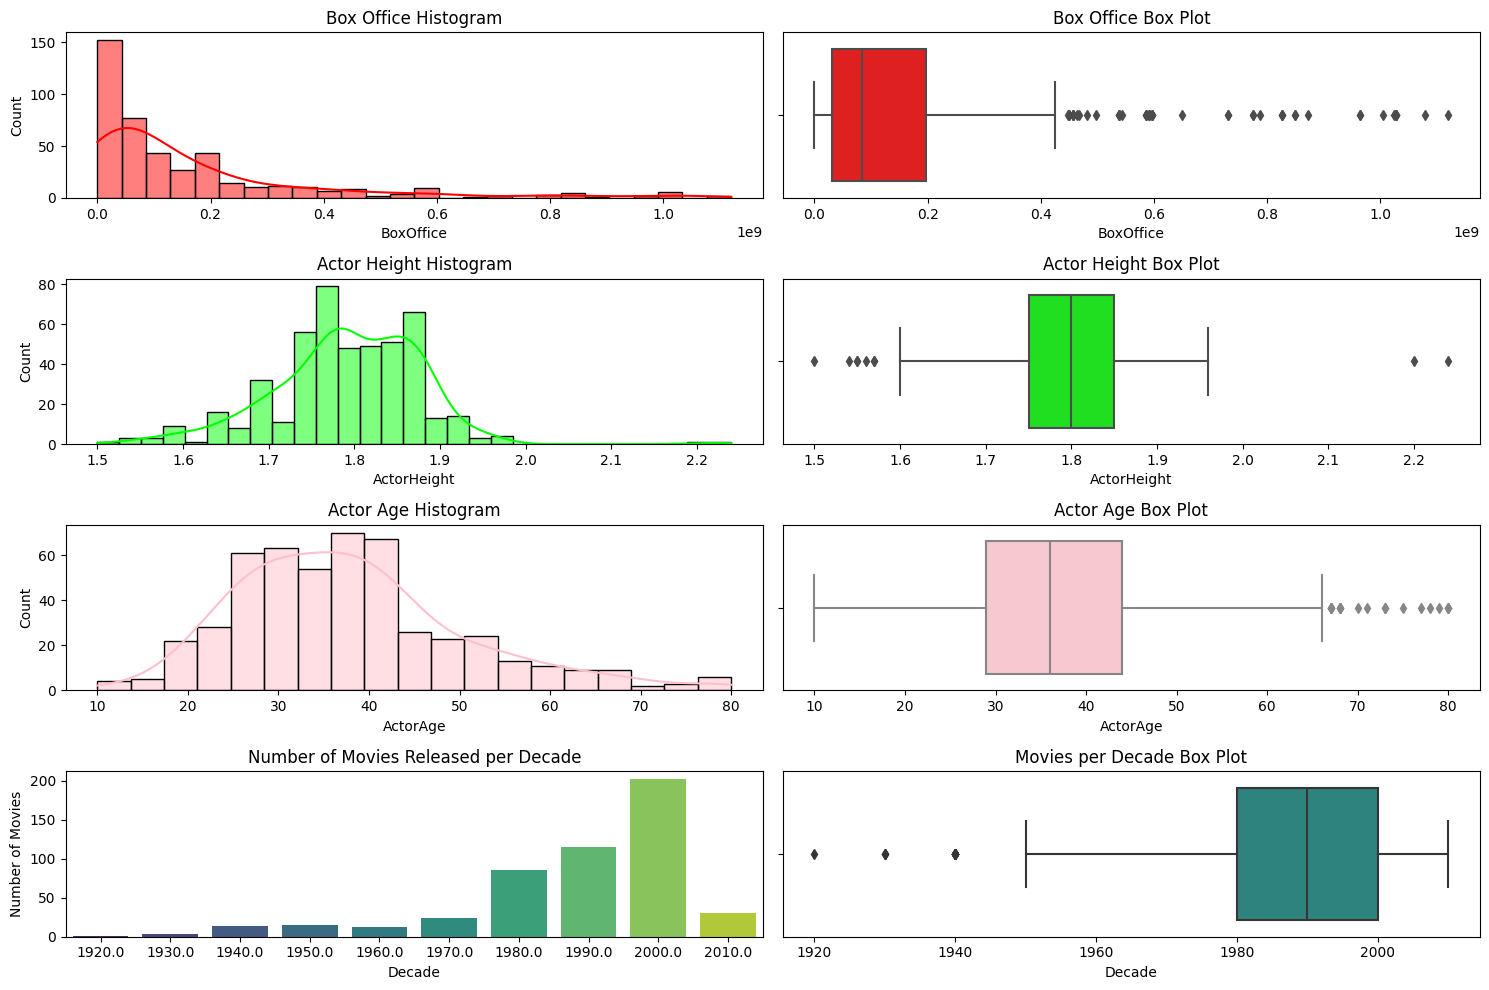

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
sns.histplot(x=tropes_characters_ethnicity_df['BoxOffice'], color = 'red', ax=axes[0,0], kde=True)
axes[0,0].set_title('Box Office Histogram')

sns.boxplot(x=tropes_characters_ethnicity_df['BoxOffice'], color = 'red', ax=axes[0,1])
axes[0,1].set_title('Box Office Box Plot')

sns.histplot(x=tropes_characters_ethnicity_df['ActorHeight'], color = 'lime', ax = axes[1,0], kde = True)
axes[1,0].set_title('Actor Height Histogram')

sns.boxplot(x=tropes_characters_ethnicity_df['ActorHeight'], color = 'lime', ax = axes[1,1])
axes[1,1].set_title('Actor Height Box Plot')

sns.histplot(x=tropes_characters_ethnicity_df['ActorAge'], color = 'pink', ax = axes[2,0], kde = True)
axes[2,0].set_title('Actor Age Histogram')

sns.boxplot(x=tropes_characters_ethnicity_df['ActorAge'], color = 'pink', ax = axes[2,1])
axes[2,1].set_title('Actor Age Box Plot')

sns.countplot(x='Decade', data=tropes_characters_ethnicity_df, palette='viridis', ax = axes[3,0])
axes[3,0].set_title('Number of Movies Released per Decade')
axes[3,0].set_xlabel('Decade')
axes[3,0].set_ylabel('Number of Movies')

sns.boxplot(x=tropes_characters_ethnicity_df['Decade'], palette = 'viridis', ax = axes[3,1])
axes[3,1].set_title('Movies per Decade Box Plot')

plt.tight_layout()
plt.show()

> + For BoxOffice, we observe a skewed power law distribution, with a large number of extreme outliers and a large concentration of movies having a low box office number (in terms of millions). <br>
> + For ActorHeight, we observe a bimodal distribution that could be explained by the presence of two populations, Female and Male actors. We will plot this distribution in function of gender to correlate with our observation. <br>
> + For Actor Age, we observe a normal distribution, with the mean being at around 37 years old. There are though a few outliers in the 70s and 80s. <br>
> + We plot the number of movies by decade. We notice a similar distribution to our initial plot of movies per decade, for movies_df. As such, our filter has not biased the decade distribution of our movies. Our boxplot shows the same skewed distribution towards the left, with a outliers in the 1920s to 1940s. <br>

#### d.ii) Bivariate EDA

##### Actor Height per Gender

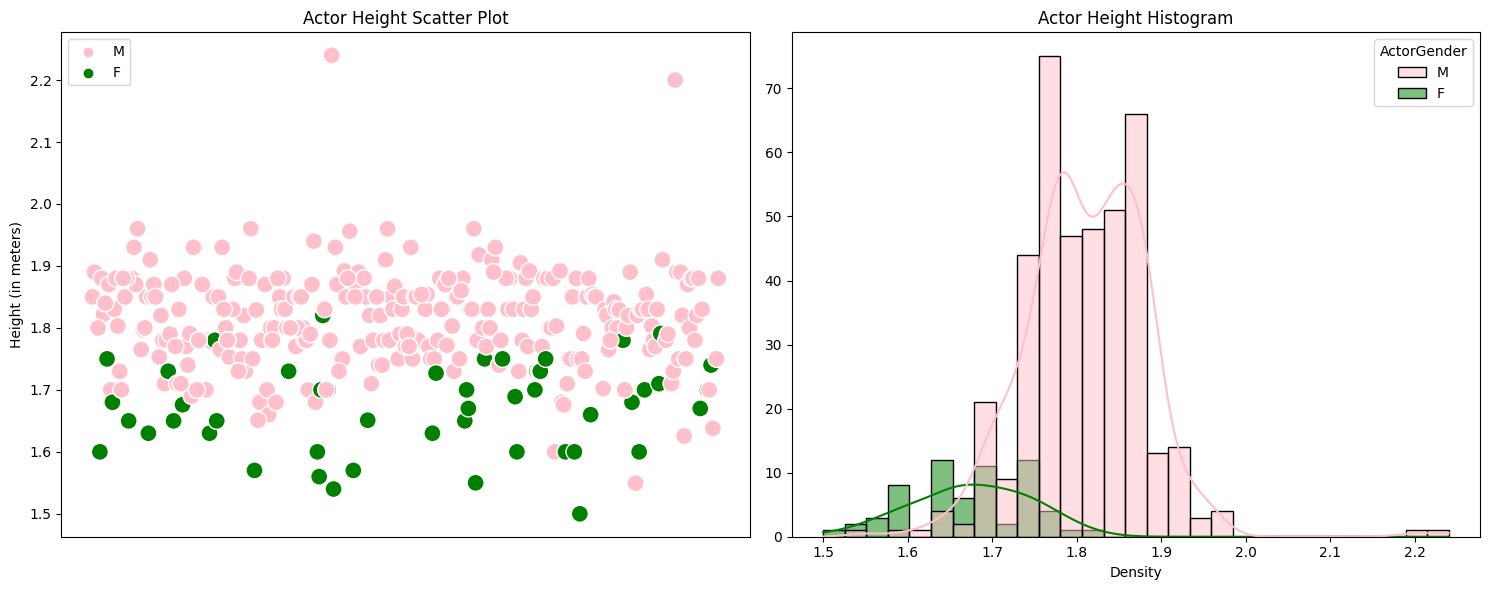

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x='ActorName', y='ActorHeight', hue='ActorGender', data=tropes_characters_ethnicity_df, 
                palette={'M': 'pink', 'F': 'green'}, s=150, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('Height (in meters)')
axes[0].set_title('Actor Height Scatter Plot')
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1))

sns.histplot(x=tropes_characters_ethnicity_df['ActorHeight'], color = 'lime', ax = axes[1], 
             hue=tropes_characters_ethnicity_df['ActorGender'],palette={'M': 'pink', 'F': 'green'}, kde = True)
axes[1].set_title('Actor Height Histogram')
axes[1].set_xlabel('Density')
axes[1].set_ylabel('')
axes[1].set_title('Actor Height Histogram')

plt.tight_layout()
plt.show()

>Our earlier hypothesis about ActorHeight distribution being a bimodal distribution sectioned by gender is wrong, as indicated in the histogram on the left. Indeed, the population of female actors is too low to impact the male actor height distribution.

##### Number of Characters per Trope

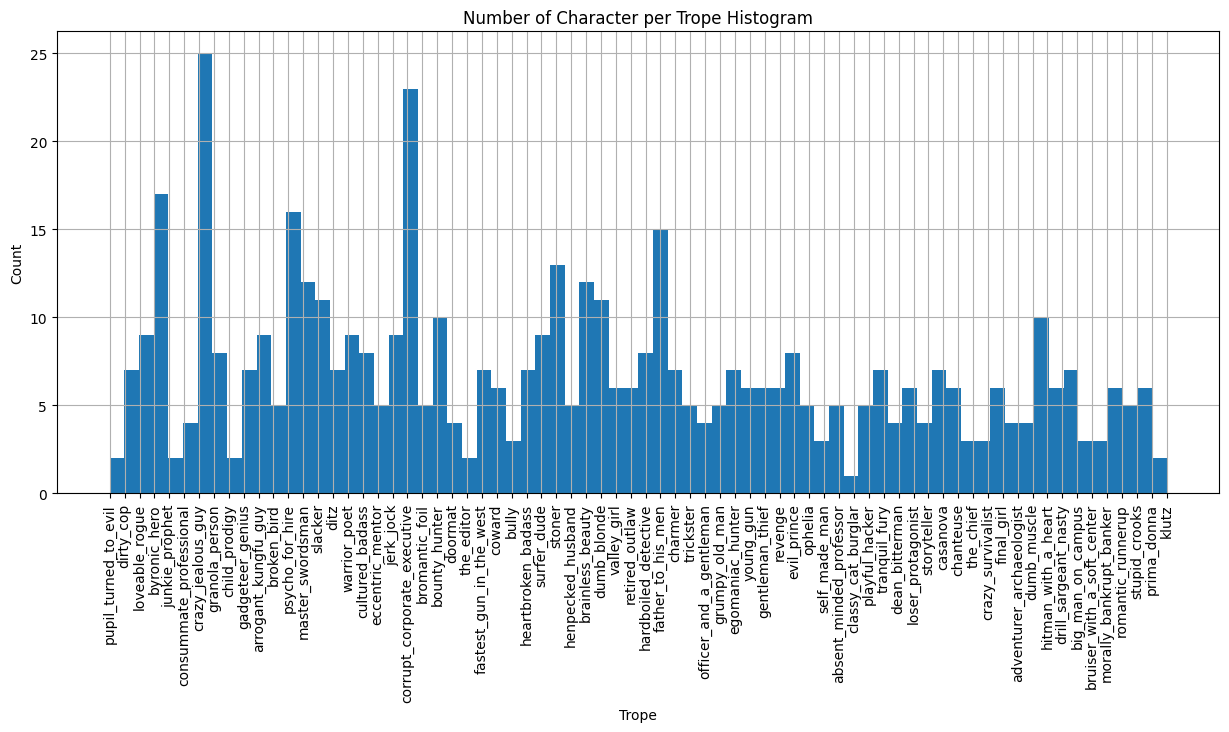

In [53]:
tropes_characters_ethnicity_df['Trope'].hist(bins=72, xrot=90,figsize=(15,6))
plt.title('Number of Character per Trope Histogram')
plt.xlabel('Trope')
plt.ylabel('Count')
plt.show()

>We plot the number of characters by tropes. We notice that some character tropes have very low numbers of characters associated, such as *classy_cat_burglar, klutz*, and, *pupil_turned_to_evil*. <br>
>A solution to this issue could be grouping similar character tropes together, for example *klutz* could be associated with *ditz* to constitute the trope *clumsy_person*.
>Sadly we do not have access to the FreebaseID Dataset that David Bamman, Brendan O'Connor, and Noah Smith used to create their unique character personas as it is not available anymore. They based themselves on key words from the plot summaries to create character maps and derive the tropes from said maps. <br>
>As such, we will opt for a more rudimentary approach by manually grouping similar tropes together. This will be done in function of their definition on [TV Tropes](https://tvtropes.org/), as used by Bamman, O'Connor & Smith and our personal knowledge.<br>

In [54]:
#Let us create the archetypes detailed above as 15 different lists
skilled_badass = ['master_swordsman', 'warrior_poet', 'cultured_badass', 'fastest_gun_in_the_west', 
                  'adventurer_archaeologist', 'hitman_with_a_heart']
loser = ['doormat', 'coward', 'henpecked_husband', 'dean_bitterman', 'loser_protagonist']
laidback_freebird = ['junkie_prophet', 'slacker', 'stoner', 'surfer_dude']
jock = ['bully', 'jerk_jock', 'dumb_muscle', 'arrogant_kungfu_guy', 'bruiser_with_a_soft_center']
charismatic_charmer = ['loveable_rogue', 'byronic_hero', 'casanova', 'charmer', 'big_man_on_campus', 
                       'gentleman_thief', 'classy_cat_burglar']
respected_leader = ['officer_and_a_gentleman', 'father_to_his_men', 'self_made_man', 'the_chief']
crazy_fighter = ['bounty_hunter', 'psycho_for_hire', 'tranquil_fury', 'crazy_survivalist']
dumb_and_clumsy = ['brainless_beauty', 'dumb_blonde', 'ditz', 'klutz', 'stupid_crooks']
shallow_and_popular = ['final_girl', 'valley_girl', 'prima_donna', 'granola_person', 'chanteuse']
old_wise_quirky = ['eccentric_mentor', 'retired_outlaw', 'hardboiled_detective', 'absent_minded_professor']
sidekick = ['romantic_runnerup', 'storyteller', 'young_gun', 'bromantic_foil']
emotional_damage = ['heartbroken_badass', 'ophelia', 'broken_bird']
evil_character = ['revenge', 'evil_prince', 'egomaniac_hunter', 'pupil_turned_to_evil', 'trickster']
mean_officer = ['consummate_professional', 'dirty_cop', 'corrupt_corporate_executive', 'the_editor', 'grumpy_old_man', 
                'drill_sargeant_nasty', 'morally_bankrupt_banker']
tech_genius = ['child_prodigy', 'gadgeteer_genius', 'playful_hacker']

In [55]:
#Replacing the tropes in tropes_character_ethnicity_df by their new grouped archetypes one by one
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=skilled_badass, 
                                                                                          value='skilled_badass')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=loser, 
                                                                                          value='loser')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=laidback_freebird, 
                                                                                          value='laidback_freebird')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=jock, 
                                                                                          value='jock')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=charismatic_charmer, 
                                                                                          value='charismatic_charmer')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=respected_leader, 
                                                                                          value='respected_leader')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=crazy_fighter, 
                                                                                          value='crazy_fighter')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=dumb_and_clumsy, 
                                                                                          value='dumb_and_clumsy')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=shallow_and_popular, 
                                                                                          value='shallow_and_popular')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=old_wise_quirky, 
                                                                                          value='old_wise_quirky')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=sidekick, 
                                                                                          value='sidekick')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=emotional_damage, 
                                                                                          value='emotional_damage')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=evil_character, 
                                                                                          value='evil_character')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=mean_officer, 
                                                                                          value='mean_officer')
tropes_characters_ethnicity_df['Trope'] = tropes_characters_ethnicity_df['Trope'].replace(to_replace=tech_genius, 
                                                                                          value='tech_genius')

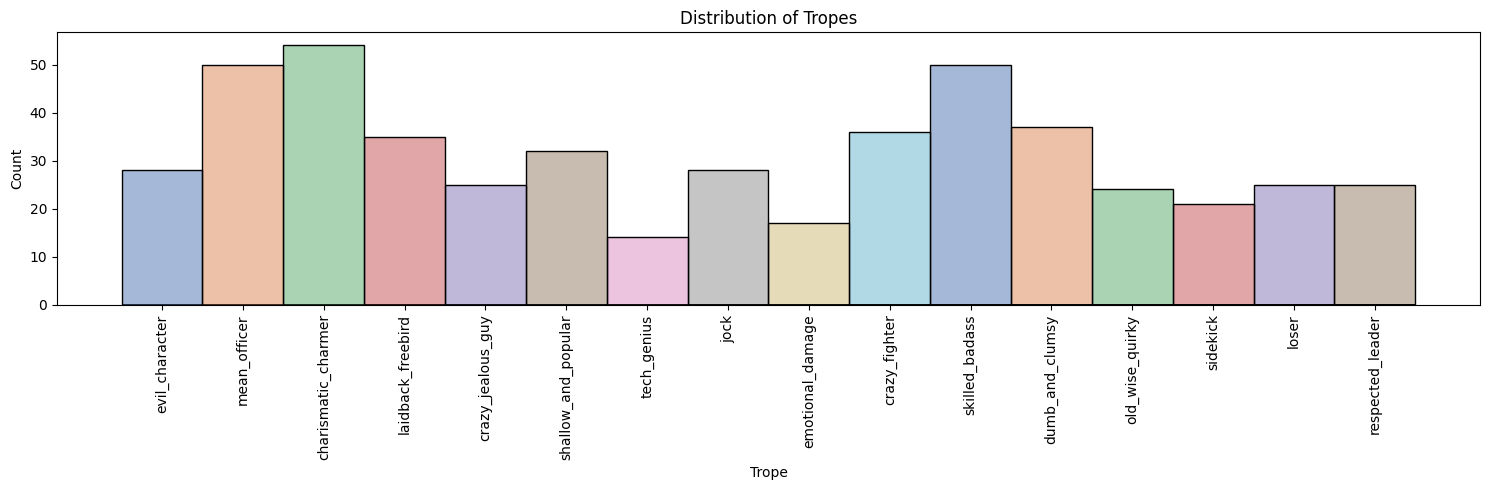

In [57]:
plt.figure(figsize=(15, 5))
trope_plot = sns.histplot(data=tropes_characters_ethnicity_df, x='Trope', bins=16, edgecolor='black', stat='count', 
             hue='Trope', palette='deep',legend = False, kde=False)
plt.xticks(rotation=90)
plt.title('Distribution of Tropes')
plt.xlabel('Trope')
plt.ylabel('Count')
plt.tight_layout()

# Show the plot
plt.show()

### Step 3: Actor Images Dataset

In this part we want to extract actors' facial encodings, in order to use them as features for classification. We are using the *actor_images.csv* file that we've created. It contains actor names, their correspoding pictures stored as a url with it's width and height. The code for that file can be found in the *people_images.ipynb* notebook.   

In [2]:
actor_images = pd.read_csv('data/our_datasets/actor_images.csv')
actor_images

,Actor,Image URL,Image height,Image width
0,Dustin Hoffman,https://image.tmdb.org/t/p/original/yFjTzJHE6A...,900,600
1,Edward Norton,https://image.tmdb.org/t/p/original/5XBzD5WuTy...,771,514
2,David Krumholtz,https://image.tmdb.org/t/p/original/6M2kk44Z1D...,1680,1120
3,Matthew Broderick,https://image.tmdb.org/t/p/original/papqFgpyro...,900,600
4,Ronny Cox,https://image.tmdb.org/t/p/original/cKkVkqft2R...,2000,1334
...,...,...,...,...
345,John Hurt,https://image.tmdb.org/t/p/original/wGDGhBOggA...,900,600
346,Schuyler Fisk,https://image.tmdb.org/t/p/original/5nQajFEGYN...,720,480
347,Laura San Giacomo,https://image.tmdb.org/t/p/original/xOPY9e0HN6...,1500,1000
348,Colin Firth,https://image.tmdb.org/t/p/original/4VBeYEUQbf...,3000,2000


In [3]:
#Finding missing values 

missing = actor_images == '-'
missing_images = actor_images[missing.any(axis=1)]
print(missing_images)

             Actor Image URL Image height Image width
69   Trevor Thomas         -          Nan         Nan
215  Peter Hinwood         -          Nan         Nan
324      Shih Kien         -          Nan         Nan


Only 0.85% of the data is missing. We will disregard it for now as it is marginal

In [4]:
#actor_images without the missing urls
actor_cleaned = actor_images[~missing.any(axis=1)]

In [17]:
#get face encodings using the face_recognition library
#this cell runs for ~10 minutes
face_encodings = {'Actor': [], 'Encodings': []}

for index, row in actor_cleaned.iterrows():
    actor_name = row['Actor']
    image_url = row['Image URL']

    # Remove spaces from actor name
    #retrieve image url
    img = requests.get(image_url)
    image_content = BytesIO(img.content)

    #transmfor the image into an array
    img = np.asarray(Image.open(image_content))
    
    #extract facial encodings (coordinates)
    face_landmarks_list = face_recognition.face_landmarks(img)

    face_encodings['Encodings'].append(face_landmarks_list)
    face_encodings['Actor'].append(actor_name)


In [16]:
#Create a Dataframe containing the facial encodings for each actor
face_encodings = pd.DataFrame(face_encodings)

Having extracted the facial encodings for each actor, we want to retrieve features that we will use for classification. For the sake of comparison between actors, we will use proportions of certain landmarks with respect to two reference measures: one for face width (distance betweem the temples) and one for the face length (distance between the top of the nose bridge and the lowest point of the chin). For exemple, we will not look at the length of a nose, but as its size in proportion to the reference length. <br>
For this milestone, we are only focussing on three features: nose length and width and distance between eyes. More features will be extracted for the final analysis. 

In [7]:
def face_proportions(row):
    try:
        landmarks = row['Encodings'][0]  # Extract the dictionary from the list
    except (json.JSONDecodeError, IndexError):
        # Handle cases where 'Encodings' is not a valid JSON or the list is empty
        return pd.Series({'Actor': row['Actor'],'Eye Distance': np.nan, 'Nose Length': np.nan, 'Nose Width': np.nan})

    
    chin_landmarks = landmarks['chin']
    nose_landmarks = landmarks['nose_bridge']
    nose_width_landmarks = landmarks['nose_tip']

    if not chin_landmarks or not nose_landmarks or not nose_width_landmarks:
        # Handle cases where expected landmarks are not available
        return pd.Series({'Actor': row['Actor'],'Eye Distance': np.nan,'Nose Length': np.nan, 'Nose Width': np.nan})

    x1 = chin_landmarks[0][0]
    x2 = chin_landmarks[-1][0]
    y1 = nose_landmarks[0][1]
    y2 = chin_landmarks[9][1]

    x_max = np.abs(x2 - x1)
    y_max = np.abs(y2 - y1)

    left_eye = landmarks.get('left_eye', [])
    right_eye = landmarks.get('right_eye', [])

    if not left_eye or not right_eye:
        eye_dist = np.nan
    else: 
        x_r = right_eye[0][0]
        x_l = left_eye[2][0]
        eye_dist = abs(x_r - x_l) / x_max


    y_nose1 = nose_landmarks[0][1]
    y_nose2 = nose_width_landmarks[-1][1]
    x_nose1 = nose_width_landmarks[0][0]
    x_nose2 = nose_width_landmarks[-1][0]

    nose_length = abs(y_nose2 - y_nose1) / y_max
    nose_width = abs(x_nose2 - x_nose1) / x_max

    return pd.Series({'Actor': row['Actor'],'Eye Distance': eye_dist, 'Nose Length': nose_length, 'Nose Width': nose_width})

In [8]:
#Apply the face_proportions function to all actors 
facial_proportions = face_encodings.apply(face_proportions, axis=1)

**Features visualisation** Now that we have obtained the features (proportions of different disctinctives facial features, such as nose length, distance between eyes, etc..)

/Users/izapomykalska/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


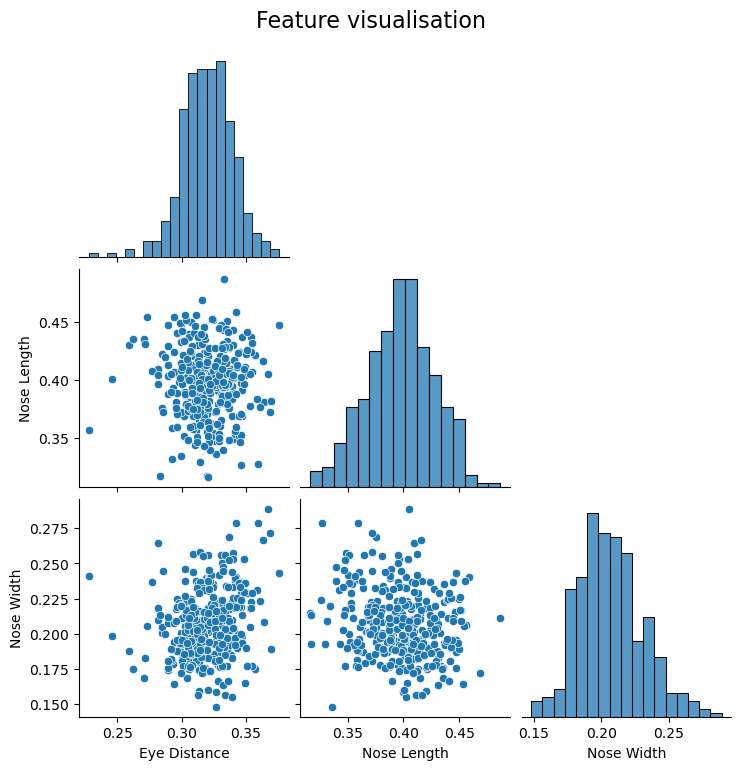

In [9]:
feature_columns = facial_proportions[['Eye Distance', 'Nose Length', 'Nose Width']]

# Create the pairplot
sns.pairplot(feature_columns, kind='scatter', diag_kind='hist', corner=True)
plt.suptitle('Feature visualisation', y=1.02, size=16)

plt.show()

We observe that the nose length is normaly distributed, whereas the eye distance and nose width are skewed to the right and left, respectively.  

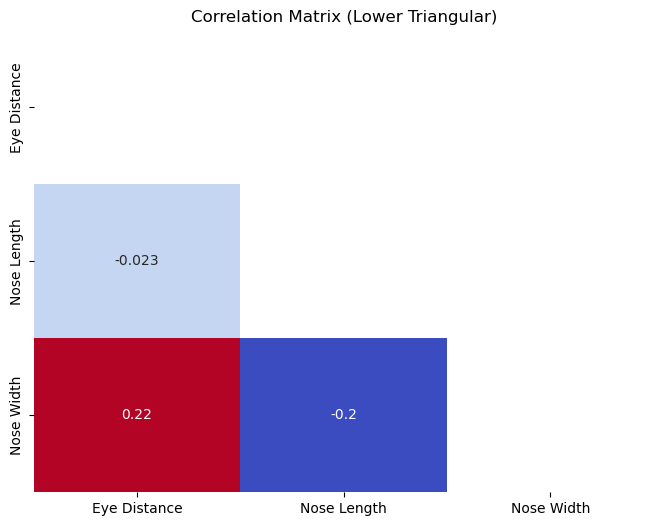

In [18]:
correlation_matrix = feature_columns.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=False, mask=mask)
plt.title('Correlation Matrix (Lower Triangular)')
plt.show()

The box plots allow us to visualise outliers . Disgarding feature outliers can improve model accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


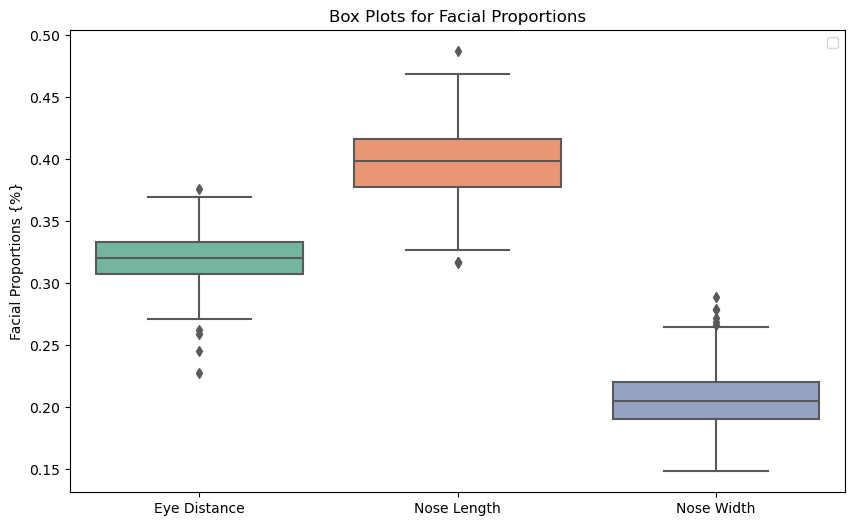

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=feature_columns, palette='Set2')
plt.title('Box Plots for Facial Proportions')
plt.ylabel('Facial Proportions {%}')
plt.legend()
plt.show()

In [12]:
column_summaries = pd.DataFrame(facial_proportions.describe())
display(column_summaries)

,Eye Distance,Nose Length,Nose Width
count,344.000000,344.000000,344.000000
mean,0.319800,0.397334,0.206836
std,0.020002,0.030028,0.023981
min,0.227702,0.316239,0.148238
25%,0.307534,0.377115,0.190181
50%,0.319919,0.398754,0.204799
75%,0.332990,0.416205,0.220166
max,0.375691,0.486880,0.288961


#### d.ii) Exploring the relations between genres and tropes

In [365]:
#Duplicates row values for each individual genre found in Genres
tropes_genres_exploded=tropes_characters_ethnicity_df.explode('Genres')

In [361]:
print('In our reduced dataset we count ' + str(tropes_genres_exploded['Genres'].nunique()) + ' unique genres')

In our reduced dataset we count 182 unique genres


Having 182 unique genres, plotting the number of tropes appearances per genre would be a mess. Instead we can plot the number of unique genres each trope appears in. Such a plot would give us an insight wether or not a trope is specific for a certain genre or if tropes in general can be found in multiple genres.

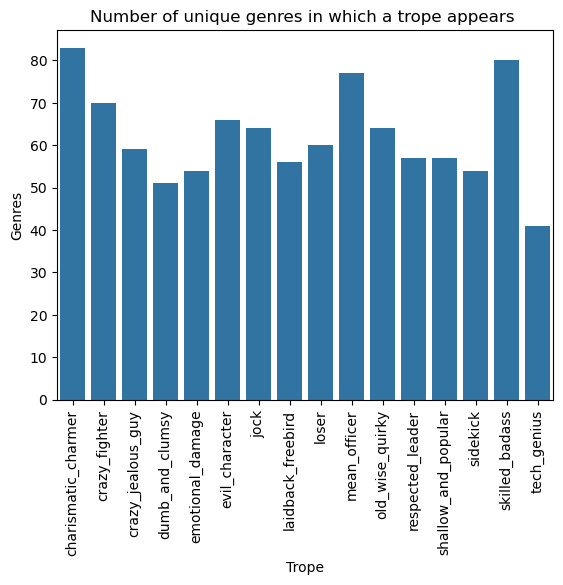

In [377]:
#Plots a histogram of the number of genres a given trope is present in
genre_count =pd.DataFrame(tropes_genres_exploded.groupby('Trope')['Genres'].nunique())
sns.barplot(data=genre_count,x=genre_count.index, y='Genres')
plt.xticks(rotation=90)
plt.title('Number of unique genres in which a trope appears ')
plt.show()

From this plot we learn that our trope categories are general enought to cover at least 40 different genres. This will enables us to compare actors characteristics for a given trope accross different genres.

### Step 3: Actor Images Dataset